In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [66]:
class Value:

    def __init__(self, data, _children:set = {}, _op = '', label=''):
        self.data = data
        self.grad = 0.00
        self._backward = lambda : None
        self._prev = _children
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = backward

        return out
    
    @staticmethod
    def sum(values:list, start=Value(0.0)):
        for value in values:
            start += value 
        return start

    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, (self, other), '-')

        def backward():
            self.grad += out.grad
            other.grad += -1.0 * out.grad
        out._backward = backward

        return out
    
    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        if other.data == 0:
            print(f"can't divide by zero.")
            return None
        out = Value(self.data / other.data, (self, other), '/')
        return out
    
    def __pow__(self, pow):
        assert isinstance(pow, (int, float)), "power must be int or float"
        out = Value(self.data ** pow, (self), f'**{pow}')

        def backward():
            if pow == -1:
                self.grad += out.grad * (-1.0 / self.data**2) 
            else:
                self.grad += out.grad * pow * self.data**(pow - 1) 
        out._backward = backward

        return out
    
    def __eq__(self, other) -> bool:
        other = other if isinstance(other, Value) else Value(other)
        return self.data == other.data
    
    def __hash__(self) -> int:
        return id(self)
    
    def __iter__(self):
        yield self
    
    def tanh(self):
        x = self.data
        t = np.tanh(x)
        out = Value(t, (self, ), 'tanh')

        def backward():
            self.grad += out.grad * (1 - t**2)

        out._backward = backward

        return out
    
    def backward(self):
        # build topological graph of nodes
        topo = []
        visitted = set()
        def build_topo(v):
            if v not in visitted:
                visitted.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        # initialize the gradient of the output to one
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

        

In [20]:
from graphviz import Digraph

def trace(root):
    #build a set of all nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangle (node) for it
        dot.node(name=uid, label= "{ %s | %0.4f | grad %0.4f}" % (n.label, n.data, n.grad), shape='record')

        if n._op:
            dot.node(name=uid + n._op, label= n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [4]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label= 'w2')
#bias term
b = Value(6.89, label='b')

x1w1 = x1*w1
x1w1.label = 'x1w1'
x2w2 = x2*w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2 
x1w1x2w2.label = 'x1w1 + x2w2'
z = x1w1x2w2 + b
z.label = 'z'
L = z.tanh()
L.label = 'L'


In [6]:
L.backward()

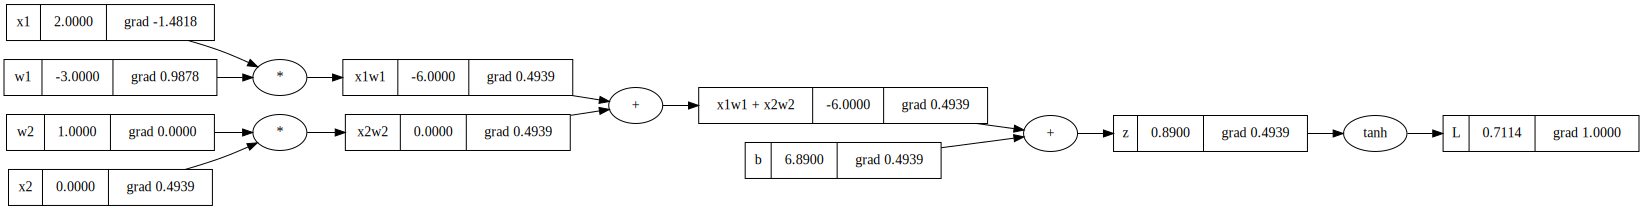

In [7]:
draw_dot(L)

In [74]:

class Neuron:

    def __init__(self, n_in) -> None:

        self.w = [Value(random.gauss(0.0, 1.0), label=f'w_{i}') for i in range(n_in)]
        self.b = Value(random.gauss(0.0, 1.0), label='b')

    def __call__(self, x):

        act = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
        out = act.tanh()

        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, n_in, n_out):

        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x):

        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:

    def __init__(self, n_in, n_outs:list):

        sz = [n_in] + n_outs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outs))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        
    # def backward(self):
    #     pass
        
        
        

In [108]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(0.9222720831656263)

In [109]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]


In [175]:
for k in range(20):
    # forward pass
    ypreds = [n(x) for x in xs]
    loss = sum([(ypred - ygt)**2 for ygt,ypred in zip(ys, ypreds)], Value(0.0))

    for p in n.parameters():
        p.grad = 0.0
    #backpropagation
    loss.backward()

    # SGD
    for p in n.parameters():
        p.data -= 0.01 * p.grad
        

    print(f"step: {k}, Loss: {loss.data}")

step: 0, Loss: 0.00542200403859749
step: 1, Loss: 0.005416942587061328
step: 2, Loss: 0.005411890649051755
step: 3, Loss: 0.005406848197687911
step: 4, Loss: 0.005401815206190288
step: 5, Loss: 0.005396791647880234
step: 6, Loss: 0.0053917774961795215
step: 7, Loss: 0.005386772724609811
step: 8, Loss: 0.005381777306792272
step: 9, Loss: 0.005376791216447014
step: 10, Loss: 0.005371814427392674
step: 11, Loss: 0.005366846913545982
step: 12, Loss: 0.005361888648921241
step: 13, Loss: 0.005356939607629917
step: 14, Loss: 0.005351999763880148
step: 15, Loss: 0.005347069091976326
step: 16, Loss: 0.005342147566318645
step: 17, Loss: 0.005337235161402628
step: 18, Loss: 0.005332331851818698
step: 19, Loss: 0.005327437612251747


In [176]:
ypreds

[Value(0.9637544763956841),
 Value(-0.9671342200474831),
 Value(-0.9603043377000856),
 Value(0.9631517363559066)]

In [ ]:
draw_dot(loss)

In [102]:
loss.backward()